In [1]:
import matplotlib.pyplot as plt
import numpy as np

from typing import List, Tuple
from matplotlib.animation import FuncAnimation

import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display
from IPython.display import Audio

from scipy.io.wavfile import read

%matplotlib notebook
%matplotlib inline

In [2]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
from speedypanther.synthesis.wave_generation import sample_sinewave, sample_complex_wave, generate_impulse_train, generate_noise, generate_timesteps
from speedypanther.analysis.fourier import fourier_analysis, dft
from speedypanther.shared.helper import normalize

## Plot a simple waveform

In [4]:
def plot_waveform(timesteps: np.ndarray, samples: np.ndarray, show_samples=False):
    plt.plot(timesteps, samples)
    if show_samples:
        plt.scatter(timesteps, samples)

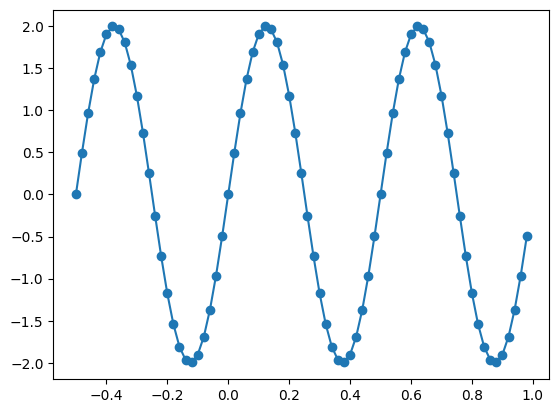

In [5]:
timesteps, samples = sample_sinewave(2, start_time = -0.5, end_time=1.0, amplitude=2, sample_rate=50)
plot_waveform(timesteps, samples, show_samples=True)

In [6]:
@widgets.interact_manual(
    freq=(0, 100), amplitude=(0.0, 50.0), sample_rate=(0, 44_100), color=['blue', 'red', 'green'], lw=(1., 10.))
def plot_waveform_interactive(freq: int = 1, amplitude: float = 1.0, sample_rate: int = 44_100, color: str = 'blue', lw: int = 1, grid: bool = True, show_samples: bool = False):
    timesteps, samples = sample_sinewave(freq, start_time = 0.0, end_time=1.0, amplitude=amplitude, sample_rate=sample_rate)
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(timesteps, samples,
            lw=lw, color=color)
    if show_samples:
        ax.scatter(timesteps, samples)
    ax.grid(grid)

interactive(children=(IntSlider(value=1, description='freq'), FloatSlider(value=1.0, description='amplitude', …

## Plot a complex waveform

In [7]:
complex_timesteps, complex_samples = sample_complex_wave(frequencies=[1, 5, 20], coeffs=[0.3, 0.2, 0.4])

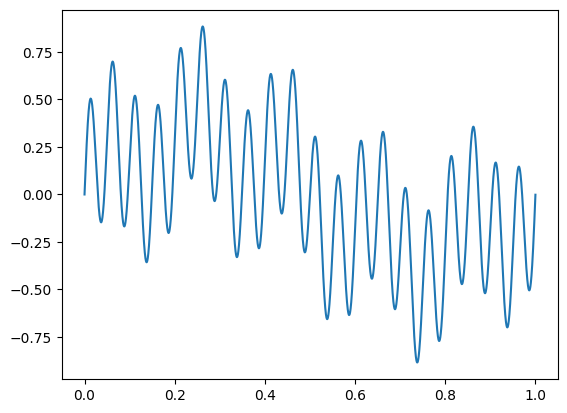

In [8]:
plot_waveform(complex_timesteps, complex_samples)

In [9]:
@widgets.interact_manual(
    freq1=(0, 100),
    freq2=(0, 100),
    freq3=(0, 100),
    coeff1=(0.0, 1.0),
    coeff2=(0.0, 1.0),
    coeff3=(0.0, 1.0))
def plot_complex_waveform_interactive(freq1=1, freq2=1, freq3=1, coeff1=0.33, coeff2=0.33, coeff3=0.33, grid=True):
    """
    Currently supports 3 waveforms mixed together.
    """
    freqs = [freq1, freq2, freq3]
    coeffs = [coeff1, coeff2, coeff3]
    timesteps, samples = sample_complex_wave(freqs, coeffs)
    
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    plt.ylim([-1.05, 1.05])
    ax.plot(timesteps, samples)
    ax.grid(grid)

interactive(children=(IntSlider(value=1, description='freq1'), IntSlider(value=1, description='freq2'), IntSli…

In [10]:
def plot_impulse_train(timesteps: np.ndarray, samples: np.ndarray):
    amplitude = samples.max()
    plt.ylim([-amplitude - amplitude * 0.1, amplitude + amplitude * 0.1])
    plt.scatter(timesteps, samples)

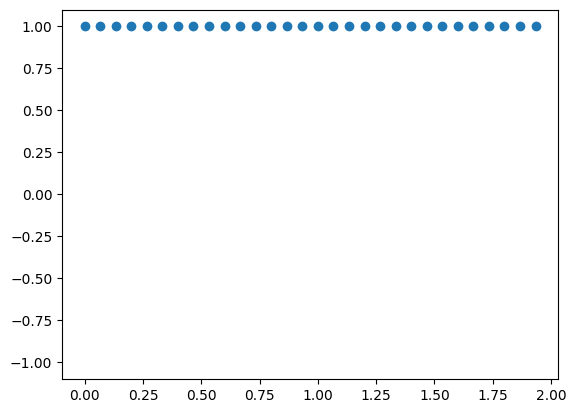

In [11]:
train_timesteps, train_samples = generate_impulse_train(15, end_time=2.0)
plot_impulse_train(train_timesteps, train_samples)

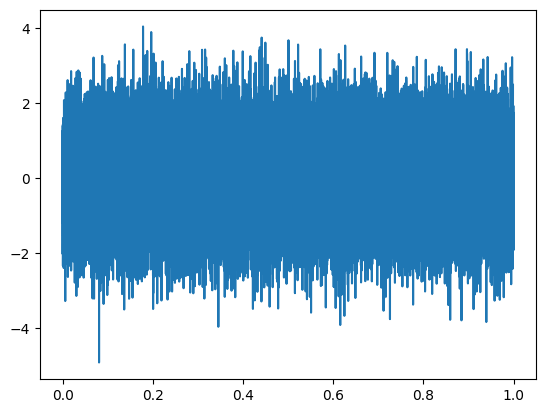

In [12]:
noise_timesteps, noise_samples = generate_noise()
plot_waveform(noise_timesteps, noise_samples)

## Fourier Analysis

In [13]:
def plot_frequencies(freq_bins: np.ndarray, freq_ampls: np.ndarray, freq_range: Tuple[int] = (0, 22_100), plot_line: bool = False):
    """
    By default only frequencies up to 3000 HZ are shown for visibility but this can be changed to any
    range between 0 and the Nyquist frequency.
    
    freq_bins: The frequencies whose amplitudes are stored.
    freq_ampls: The amplitudes for the respective frequencies.
    """
    plt.xlim(*freq_range)
    if plot_line:
        plt.plot(freq_bins, freq_ampls)
        plt.scatter(freq_bins, freq_ampls)
        
    else:
        plt.stem(freq_bins, freq_ampls)

In [14]:
# Create a new complex wave to play around with.
_, complex_wave = sample_complex_wave(frequencies=[600, 800, 1000, 1600], coeffs=[0.3, 0.2, 0.4, 0.1], end_time=0.1)

duration = 0.005
sample_rate = 44_100
# Take a window of samples out of the complex wave.
sample_window = complex_wave[:int(duration * sample_rate)]

# Turn the time representation of the wave into a frequency representation.
freq_bins, freq_ampls = fourier_analysis(sample_window, duration, sample_rate)

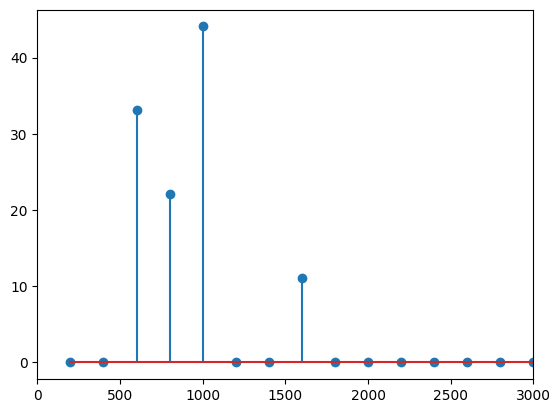

In [15]:
plot_frequencies(freq_bins, freq_ampls, plot_line=False, freq_range=(0, 3000))

## Use the FFT function from numpy to generate frequency bins

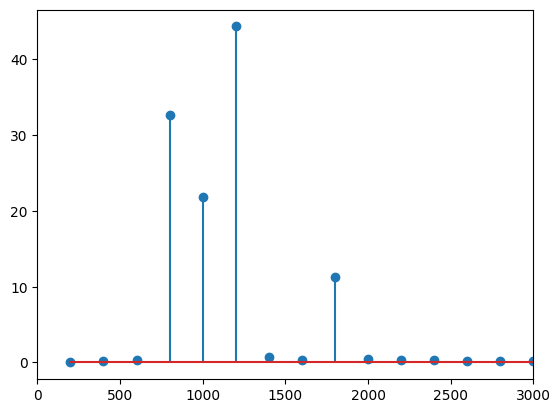

In [16]:
nyquist_freq = freq_bins.shape[0]
fft_freq_ampls = np.fft.fft(sample_window)
# Since the FFT function even outputs bins above the Nyquist frequency, we can cut it off there.
plot_frequencies(freq_bins, np.abs(fft_freq_ampls[:nyquist_freq]), plot_line=False, freq_range=(0, 3000))

## Read a real soundfile 

In [17]:
coo_file = "../data/single_words/vowels/Monophthongs/11-coo.wav"
coo_sr, coo = read(coo_file)
coo_arr = np.array(coo, dtype=float)

# Only take the first channel for now.
coo_arr = coo_arr[:, 0]

# Generate timesteps to be able to plot the wave.
coo_timesteps = generate_timesteps(coo_arr)

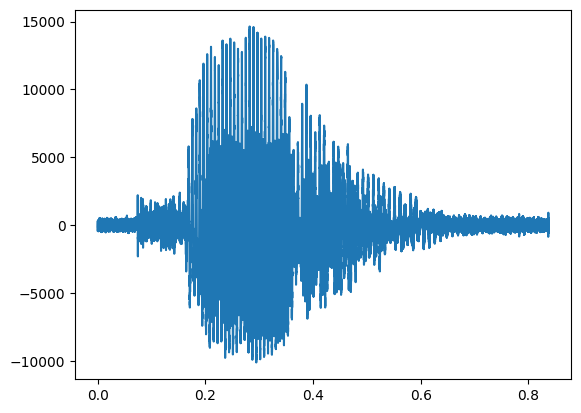

In [18]:
plot_waveform(coo_timesteps, coo_arr)

## Plot Frequency Representations for short analysis windows produced with Fourier Analysis

In [19]:
# Take the first window of x milliseconds and apply Fourier Analysis to it.
audio_length = coo_arr.shape[0] / sample_rate

# Window length in milliseconds.
window_duration = 0.005
samples_per_window = int(sample_rate * window_duration)
first_window = coo_arr[:samples_per_window]

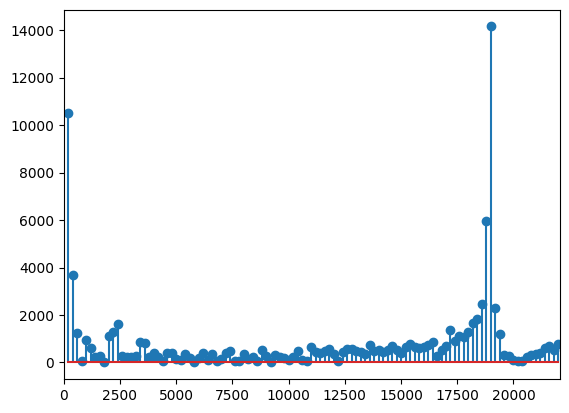

In [20]:
# Calculate the frequency strengths using Fourier Analysis
first_freq_bins, first_freq_ampls = fourier_analysis(first_window, duration=window_duration)
plot_frequencies(first_freq_bins, np.abs(first_freq_ampls), freq_range=(0, sample_rate / 2))

## Use the FFT function from numpy to generate frequency bins for the real sound

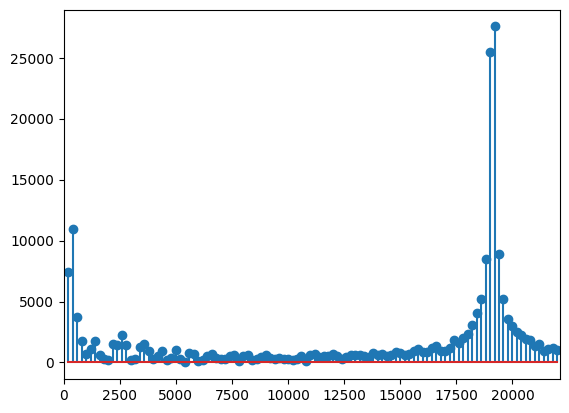

In [21]:
fft_first_freq_ampls = np.fft.fft(first_window)
# Since the FFT function even outputs bins above the Nyquist frequency, we can cut it off there.
plot_frequencies(first_freq_bins, np.abs(fft_first_freq_ampls[:nyquist_freq]), plot_line=False)

## Use the Fourier Transform to generate frequency bins for the real /u/ sound

In [22]:
# Plot for a window that is inside the /u/ sound.
start = 40 * samples_per_window
end = start + samples_per_window
u_window = first_window = coo_arr[start:end]

u_freq_bins, u_freq_ampls = fourier_analysis(u_window, duration=window_duration)

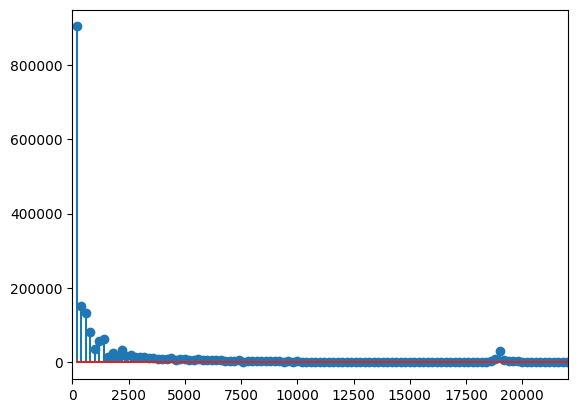

In [23]:
plt.xlim(0, 10000)
# norm_u_ampls = normalize(u_freq_ampls)
plot_frequencies(u_freq_bins, np.abs(u_freq_ampls), freq_range=(0, sample_rate / 2))

## Use the FFT function from numpy to generate frequency bins for the real /u/ sound

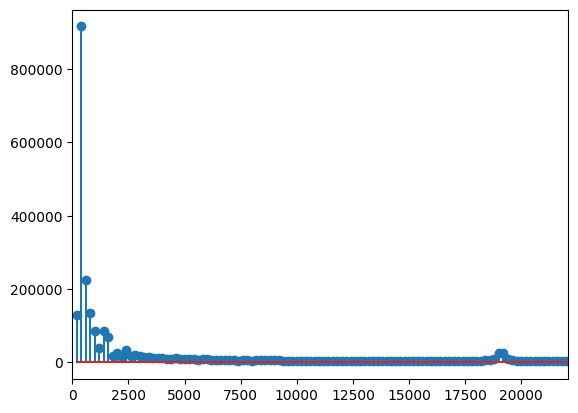

In [24]:
fft_u_freq_ampls = np.fft.fft(u_window)
# Since the FFT function even outputs bins above the Nyquist frequency, we can cut it off there.
plot_frequencies(u_freq_bins, np.abs(fft_u_freq_ampls[:nyquist_freq]))

## Use the custom DFT function to generate frequency bins for the real /u/ sound

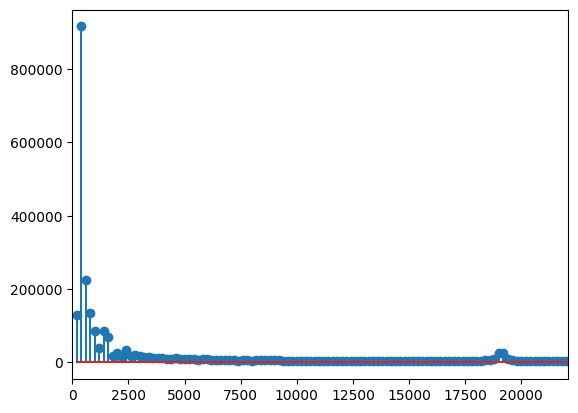

In [25]:
dft_u_freq_ampls = dft(u_window)
plot_frequencies(u_freq_bins, np.abs(dft_u_freq_ampls[:nyquist_freq]))

## Play audios to inspect the analyzed sounds

In [26]:
print("A single frame from the /u/ sound.")
Audio(u_freq_ampls, rate=sample_rate)

A single frame from the /u/ sound.


In [27]:
start = 40 * samples_per_window
length = 60
end = start + (length * samples_per_window)
part = first_window = coo_arr[start:end]

print("A longer window (20 * window_size) from the /u/ sound.")
Audio(part, rate=sample_rate)

A longer window (20 * window_size) from the /u/ sound.
